# May-3 Transfer learning

In [117]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import copy
from torchsummary import summary

In [53]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

## Getting Letters datasets ready

In [54]:
letters = torchvision.datasets.EMNIST(root="emnist", split="letters", download=True)
numbers = torchvision.datasets.EMNIST(root="emnist", split="digits", download=True)

In [55]:
letter_cats = letters.classes[1:]
llabels = copy.deepcopy(letters.targets) - 1

In [56]:
letter_images = letters.data.view([letters.data.shape[0], 1, 28, 28]).float()
letter_images = letter_images / torch.max(letter_images)

In [57]:
ltrain_data, ltest_data, ltrain_labels, ltest_labels = train_test_split(letter_images, llabels, test_size=0.1)
ltrain_data = TensorDataset(ltrain_data, ltrain_labels)
ltest_data = TensorDataset(ltest_data, ltest_labels)

ltrain_loader = DataLoader(ltrain_data, batch_size=32, shuffle=True, drop_last=True)
ltest_loader = DataLoader(ltest_data, batch_size=ltest_data.tensors[0].shape[0])

## Getting Digits Dataset ready

In [58]:
number_images = numbers.data.view([numbers.data.shape[0], 1, 28, 28]).float()
number_images /= torch.max(number_images)

In [59]:
nlabels = numbers.targets
nlabels

tensor([8, 9, 6,  ..., 1, 1, 0])

In [60]:
ntrain_data, ntest_data, ntrain_labels, ntest_labels = train_test_split(number_images, nlabels, test_size=0.1)
ntrain_data = TensorDataset(ntrain_data, ntrain_labels)
ntest_data = TensorDataset(ntest_data, ntest_labels)

ntrain_loader = DataLoader(ntrain_data, batch_size=32, shuffle=True, drop_last=True)
ntest_loader = DataLoader(ntest_data, batch_size=ntest_data.tensors[0].shape[0])

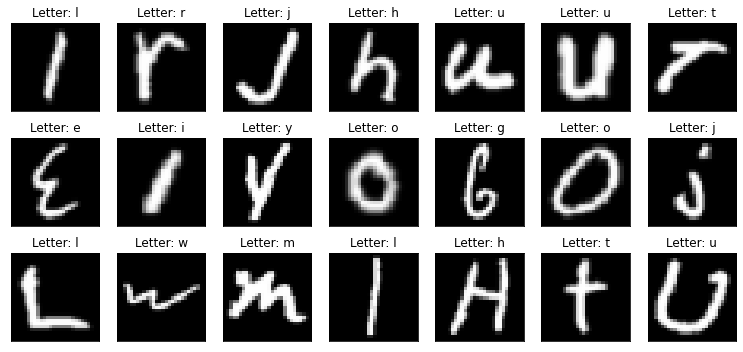

In [61]:
fig, axs = plt.subplots(3, 7, figsize=(13, 6))
x, y = next(iter(ltrain_loader))

for i, ax in enumerate(axs.flatten()):
  I = np.squeeze(x[i, :, :])
  current = letter_cats[y[i]]
  ax.imshow(I.T, cmap="gray", vmin=0, vmax=1)
  ax.set_title(f"Letter: {current}")
  ax.set_yticks([])
  ax.set_xticks([])

plt.show()

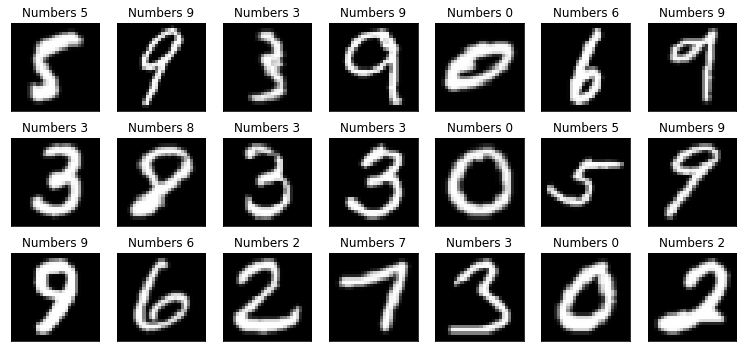

In [62]:
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

x, y = next(iter(ntrain_loader))

for i, ax in enumerate(axs.flatten()):
  I = np.squeeze(x[i, :, :])
  ax.imshow(I.T, cmap="gray", vmin=0, vmax=1
            )
  ax.set_title(f"Numbers {y[i]}")
  ax.set_yticks([])
  ax.set_xticks([])
plt.show()

## Building CNNs Models

In [89]:
def build_letters_model():
    class createModel(nn.Module):
        def __init__(self):
          super().__init__()
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1)
          self.batch_norm_1 = nn.BatchNorm2d(6)
          self.conv2 = nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3, padding=1)
          self.batch_norm_2 = nn.BatchNorm2d(6)
          self.linear_1 = nn.Linear(6 * 7 * 7, 50)
          self.linear_2 = nn.Linear(50, 26)
        
        # forward pass
        def forward(self, x):
          # 1st CNNs layer
          x = F.max_pool2d(self.conv1(x), 2)
          x = F.leaky_relu(self.batch_norm_1(x))
          # 2nd CNNs layer
          x = F.max_pool2d(self.conv2(x), 2)
          x = F.leaky_relu(self.batch_norm_2(x))
          x = x.view(-1, 6 * 7 * 7)
          x = F.leaky_relu(self.linear_1(x))
          return self.linear_2(x)
    model = createModel()
    Loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, Loss, optimizer
  

In [91]:
# Testing the model
net, LLoss, ooptimizer = build_letters_model()
net = net.to(device)
x, y = iter(ltrain_loader).next()
x = x.to(device)
y = y.to(device)
print(x.shape, y.shape)
yh = net(x)
loss = LLoss(yh, y)
torch.argmax(yh, axis=1) == y

torch.Size([32, 1, 28, 28]) torch.Size([32])


tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False], device='cuda:0')

## Training letters Model

In [96]:
def train_model(model, Loss, optimizer, train_loader, test_loader, epochs=10):
    model = model.to(device)
    train_accuracy = []
    test_accuracy = []
    train_loss = []
    test_loss = []

    for i in range(epochs):
        batch_acc = []
        batch_loss = []
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            # forward push
            yh = model(x)
            loss = Loss(yh, y)
            # backward push
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Computing batch performance
            batch_loss.append(loss.item())
            correct = (torch.argmax(yh, axis=1) == y).float()
            batch_acc.append(100 * torch.mean(correct.cpu()))
        
        # Computing total batch performance
        train_accuracy.append(np.mean(batch_acc))
        train_loss.append(np.mean(batch_loss))
        # Computing test performance
        x, y = next(iter(test_loader))
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
          yh = model(x)
          loss = Loss(yh, y)
        test_loss.append(loss.item())
        correct = (torch.argmax(yh, axis=1) == y).float()
        test_accuracy.append(100 * torch.mean(correct))
        print(f"Train acc: {train_accuracy[-1]}, Test acc: {test_accuracy[-1]}")
    return model, train_accuracy, train_loss, test_accuracy, test_loss

In [97]:
net, Loss, optimizer = build_letters_model()
model, train_accuracy, train_loss, test_accuracy, test_loss = train_model(net, Loss, optimizer, ltrain_loader, ltest_loader)

Train acc: 82.2943344116211, Test acc: 88.52564239501953
Train acc: 89.78276062011719, Test acc: 90.3525619506836
Train acc: 90.95708465576172, Test acc: 90.87340545654297
Train acc: 91.58297729492188, Test acc: 91.01763153076172
Train acc: 92.04059600830078, Test acc: 91.26602935791016
Train acc: 92.37268829345703, Test acc: 91.84294891357422
Train acc: 92.71456909179688, Test acc: 91.75481414794922
Train acc: 92.8641357421875, Test acc: 91.38622283935547
Train acc: 93.03418731689453, Test acc: 92.00321197509766
Train acc: 93.23272705078125, Test acc: 91.7147445678711


## Fine tunning the model

In [103]:
# Testing on numbers data
x, y = next(iter(ntrain_loader))
x = x.to(device)
y = y.to(device)

with torch.no_grad():
  yh = net(x)
print(100 * torch.mean((torch.argmax(yh, axis=1) == y).float()).cpu())

tensor(6.2500)


In [104]:
new_model, Loss, optimizer = build_letters_model()

In [106]:
# copying weights
for x, y in zip(new_model.named_parameters(), net.named_parameters()):
  x[1].data = copy.deepcopy(y[1].data)

In [109]:
new_model.linear_2 = nn.Linear(50, 10)

for p in new_model.named_parameters():
    if not "linear_2" in p[0]:
      p[1].requires_grad = True

In [110]:
res_model, train_accuracy, train_loss, test_accuracy, test_loss = train_model(new_model, Loss, optimizer, ntrain_loader, ntest_loader, 2)

Train acc: 97.125, Test acc: 98.8083267211914
Train acc: 98.90694427490234, Test acc: 98.99166870117188


## Training Model with tf ResNet18 

In [134]:
trans = T.Compose([
                   T.ToTensor(),
                   T.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
])

train_set = torchvision.datasets.STL10(root="./data", download=True, split="train",
                                       transform=trans)
test_set = torchvision.datasets.STL10(root="./data", download=True, split="test",
                                      transform=trans)

Files already downloaded and verified
Files already downloaded and verified


In [135]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=256)

In [136]:
resnet = torchvision.models.resnet18(pretrained=True)

In [137]:
summary(resnet.to(device), (3, 96, 96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           9,408
       BatchNorm2d-2           [-1, 64, 48, 48]             128
              ReLU-3           [-1, 64, 48, 48]               0
         MaxPool2d-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          36,864
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          36,864
       BatchNorm2d-9           [-1, 64, 24, 24]             128
             ReLU-10           [-1, 64, 24, 24]               0
       BasicBlock-11           [-1, 64, 24, 24]               0
           Conv2d-12           [-1, 64, 24, 24]          36,864
      BatchNorm2d-13           [-1, 64, 24, 24]             128
             ReLU-14           [-1, 64,

In [120]:
for p in resnet.parameters():
    p.requires_grad = False

In [138]:
resnet.fc = nn.Linear(512, 10)

In [139]:
optimizer = torch.optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)
Loss = nn.CrossEntropyLoss()

In [123]:
res_model, train_accuracy, train_loss, test_accuracy, test_loss = train_model(resnet, Loss, optimizer, train_loader, test_loader, 5)

Train acc: 57.41185760498047, Test acc: 73.4375
Train acc: 75.56089782714844, Test acc: 77.34375
Train acc: 78.10496520996094, Test acc: 78.125
Train acc: 79.76763153076172, Test acc: 78.125
Train acc: 79.96794891357422, Test acc: 76.171875


In [130]:
for p in resnet.parameters():
    p.requires_grad = True

In [140]:
res_model, train_accuracy, train_loss, test_accuracy, test_loss = train_model(resnet, Loss, optimizer, train_loader, test_loader, 15)

Train acc: 69.81169891357422, Test acc: 85.9375
Train acc: 91.88701629638672, Test acc: 88.671875
Train acc: 95.87339782714844, Test acc: 89.0625
Train acc: 98.21714782714844, Test acc: 87.5
Train acc: 99.13861846923828, Test acc: 89.0625
Train acc: 99.53926086425781, Test acc: 88.671875
Train acc: 99.69951629638672, Test acc: 89.84375
Train acc: 99.7996826171875, Test acc: 89.0625
Train acc: 99.81970977783203, Test acc: 89.84375
Train acc: 99.7996826171875, Test acc: 88.28125
Train acc: 99.87980651855469, Test acc: 88.671875
Train acc: 99.89984130859375, Test acc: 89.453125
Train acc: 99.85977935791016, Test acc: 88.671875
Train acc: 99.87980651855469, Test acc: 89.0625
Train acc: 99.87980651855469, Test acc: 88.671875
